# Settings

In [1]:
#@title imports
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [2]:
#@title constants

# FILE = './sonnets.txt'
FILE = './irish-lyrics-eof.txt'

EMBEDDING_DIM = 100 # 100
LSTM_DIM = 150     # 150
DENSE_DIM = 150
LR = 0.001
EPOCHS = 100

In [3]:
#@title downloads
%%capture

# irish songs
!gdown --id 15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT

# shakespeare sonets
# !gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

In [4]:
#@title functions
def plot_graphs(history, string):
  plt.rcParams['figure.figsize'] = [5, 2]
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Building the Word Vocabulary

In [5]:
# # lyrics of Lanigan's Ball
# data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

# corpus = data.lower().split("\n")
# print(corpus)

In [5]:
data = open(FILE).read()
corpus = data.lower().split("\n")

print(corpus)

['from fairest creatures we desire increase,', "that thereby beauty's rose might never die,", 'but as the riper should by time decease,', 'his tender heir might bear his memory:', 'but thou, contracted to thine own bright eyes,', "feed'st thy light'st flame with self-substantial fuel,", 'making a famine where abundance lies,', 'thyself thy foe, to thy sweet self too cruel.', "thou that art now the world's fresh ornament", 'and only herald to the gaudy spring,', 'within thine own bud buriest thy content', 'and, tender churl, makest waste in niggarding.', 'pity the world, or else this glutton be,', "to eat the world's due, by the grave and thee.", 'when forty winters shall beseige thy brow,', "and dig deep trenches in thy beauty's field,", "thy youth's proud livery, so gazed on now,", "will be a tatter'd weed, of small worth held:", "then being ask'd where all thy beauty lies,", 'where all the treasure of thy lusty days,', 'to say, within thine own deep-sunken eyes,', 'were an all-eating

In [6]:
# Generate the word index dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1 # index `0` is padding token.

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'love': 14, 'not': 15, 'but': 16, 'a': 17, 'me': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'his': 25, 'which': 26, 'when': 27, 'it': 28, 'this': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'then': 38, 'have': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'beauty': 51, 'nor': 52, 'eyes': 53, 'art': 54, 'her': 55, 'heart': 56, 'yet': 57, 'o': 58, 'than': 59, 'can': 60, 'should': 61, 'thine': 62, 'now': 63, 'where': 64, 'make': 65, 'one': 66, 'hath': 67, 'he': 68, 'fair': 69, 'still': 70, 'how': 71, 'eye': 72, 'him': 73, 'like': 74, 'true': 75, 'see': 76, 'am': 77, 'she': 78, 'those': 79, 'though': 80, 'being': 81, 'some': 82, 'every': 83, 'such': 84, 'own': 85, 'were': 86, 'dos

# Preprocessing

We will generate the training sequences and their labels. For example, if we have one sentence: "I am using Tensorflow", we want the model to learn the next word given any subphrase of this sentence:

```
INPUT              LABEL
-----------------------------
I             ---> am
I am          ---> using
I am using    ---> Tensorflow
```

In [7]:
input_sequences = []

for line in corpus:
  # tokenize line
  token_list = tokenizer.texts_to_sequences([line])[0] # ex.: [4, 2, 66, 8, 67, 68, 69, 70]

  # loop over the line several times to generate the subphrases
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence) # [..., [4, 2], [4, 2, 66], [4, 2, 66, 8], ...]

max_sequence_len = max([len(x) for x in input_sequences])
# pad sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) # [..., [ 0  0  0  0  0  0  4  2 66  8 67], ...]
# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [9]:
sentence = corpus[0].split()[:-1]
print(f'sample sentence: {sentence}')
tokenized_sentence = [tokenizer.word_index[word] for word in sentence]
print(f'tokenized sample sentence: {tokenized_sentence}')
print(f'padded n-grams:\n {input_sequences[:8]}')
print(f'X:\n {xs[:8]}')
print(f'labels:\n {labels[:8]}')

sample sentence: ['from', 'fairest', 'creatures', 'we', 'desire']
tokenized sample sentence: [34, 417, 877, 166, 213]
padded n-grams:
 [[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0  34 417 877 166 213 517]
 [  0   0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   0   8 878 134]
 [  0   0   0   0   0   0   0   8 878 134 351]]
X:
 [[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0  34 417 877 166]
 [  0   0   0   0   0  34 417 877 166 213]
 [  0   0   0   0   0   0   0   0   0   8]
 [  0   0   0   0   0   0   0   0   8 878]
 [  0   0   0   0   0   0   0   8 878 134]]
labels:
 [417 877 166 213 517 878 134 351]


In [10]:
# one-hot encoded value can be converted back using np.argmax() function
print(f"one-hot encoded label (token) '{np.argmax(ys[0])}':\n {ys[0]}")

one-hot encoded label (token) '417':
 [0. 0. 0. ... 0. 0. 0.]


# Training

In [11]:
model = Sequential([
          Embedding(total_words, EMBEDDING_DIM, input_length=max_sequence_len-1),
          # Bidirectional(LSTM(LSTM_DIM)),
          LSTM(LSTM_DIM),
          # Dense(DENSE_DIM, activation='relu'),
          Dense(total_words, activation='softmax')
])
adam = Adam(learning_rate=LR)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 3211)              484861    
                                                                 
Total params: 956,561
Trainable params: 956,561
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(xs, ys, epochs=EPOCHS, verbose=1)

Epoch 1/100
484/484 [==============================] - 22s 25ms/step - loss: 6.8912 - accuracy: 0.0251
Epoch 2/100
484/484 [==============================] - 4s 8ms/step - loss: 6.4683 - accuracy: 0.0295
Epoch 3/100
484/484 [==============================] - 4s 9ms/step - loss: 6.3003 - accuracy: 0.0387
Epoch 4/100
484/484 [==============================] - 3s 6ms/step - loss: 6.1080 - accuracy: 0.0448
Epoch 5/100
484/484 [==============================] - 4s 8ms/step - loss: 5.9019 - accuracy: 0.0528
Epoch 6/100
484/484 [==============================] - 3s 6ms/step - loss: 5.6575 - accuracy: 0.0633
Epoch 7/100
484/484 [==============================] - 3s 7ms/step - loss: 5.3986 - accuracy: 0.0741
Epoch 8/100
484/484 [==============================] - 4s 7ms/step - loss: 5.1367 - accuracy: 0.0834
Epoch 9/100
484/484 [==============================] - 3s 6ms/step - loss: 4.8764 - accuracy: 0.0996
Epoch 10/100
484/484 [==============================] - 3s 6ms/step - loss: 4.6179 - accu

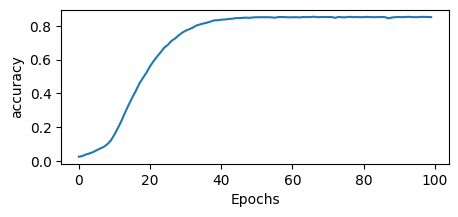

In [13]:
  # Visualize the accuracy
plot_graphs(history, 'accuracy')

# Generate text

In [36]:
%%capture
seed_text = "My glass shall not"

# Define total words to predict
next_words = 24

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence to match the training set
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)


	# predicted = np.argmax(probabilities, axis=-1)[0] # Get the index with the highest probability, more frequent word repetitions ?
  choice = np.random.choice([1,2,3])
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		# Look up the word associated with the index.
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word

In [37]:
# output the result
print(seed_text)

My glass shall not a better part doth me hate ill wrong new mask'd now be store long so dumb tongue end eyes knows home in the deep
